In [27]:
# Load dataset
import torch

# Parameters
num_epochs = 100
num_samples = 10000
num_features = 128
rank = 8  # MPS rank
n_cores = 32 # max_monomial_degree
d_in = (num_features // n_cores)

# Generate random x data
x = torch.randn(num_samples, num_features)

# Define polynomial function
def poly_fn(x):
    return x.abs().sum()

def add_bias(batch):
    # Stack tensors
    x, y = zip(*batch)  # unzip list of tuples into two tuples
    x = torch.stack(x, dim=0)
    y = torch.stack(y, dim=0)
   
    # Reshape x to be (B, H, D_in)
    x = x.reshape(x.size(0), n_cores, d_in)

    # Add bias term
    x = torch.cat([torch.ones(x.size(0), x.size(1), 1), x], dim=-1)
    return x, y

# Use torch.vmap to vectorize polynomial computation
y = torch.vmap(poly_fn)(x)
y = y.unsqueeze(1)  # (num_samples, 1)

# Create tensor dataset
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=add_bias)


In [28]:
from tqdm import tqdm
from ptn.regressors.mps import MPS_REGRESSOR
from ptn.regressors._abc import AbstractRegressorHeadConfig


sample_batch = next(iter(dataloader))
x, y = sample_batch

model = MPS_REGRESSOR(
    AbstractRegressorHeadConfig(
        d_in=x.size(-1),
        d_out=y.size(-1),
        horizon=x.size(1),
        rank=rank,
    )
)

losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for batch in dataloader:
        optimizer.zero_grad()
        x, y = batch
        output = model(x, y)
        loss = output.loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    pbar.set_postfix(loss=loss.item())

print("Training complete.")



 41%|████      | 41/100 [02:24<03:27,  3.52s/it, loss=1.27]


KeyboardInterrupt: 

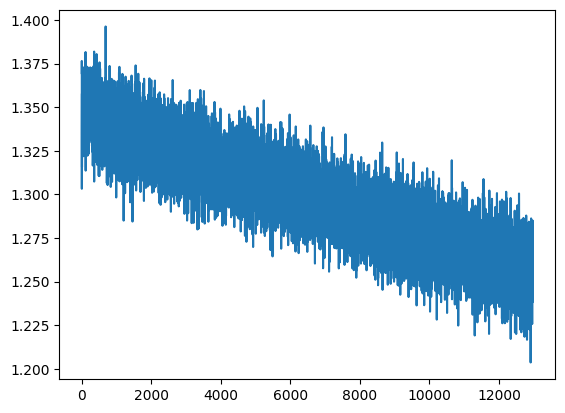

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(losses)), y=losses)
plt.show()
